In [1]:
import sys
sys.path.append('../mlai_research/')
import log
import utils
import cv2
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2hsv
from skimage.filters import threshold_sauvola
from skimage.segmentation import mark_boundaries
import rasterio
import glob
import matplotlib.pyplot as plt

In [2]:
logger = log.get_logger(__name__)
conf = utils.load_config('base')

13-Nov-23 20:16:25 - INFO - Starting 'load_config'.
13-Nov-23 20:16:25 - INFO - Finished 'load_config' in 0.0187 secs.


In [3]:
def load_cropped_tifs(path):
    return glob.glob(f'{path}*.tif')

def normalize_image(image):
    normalized_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    logger.info(f'Normalized image shape: {normalized_image.shape}')
    return normalized_image

def process_rgb_image(image):
    # Add your RGB processing logic here
    img_rgb = image[:,:,:3]
    logger.info(f'RGB image shape: {img_rgb.shape}')
    return img_rgb

def get_segments(image):
    # Add your segmentation logic here
    segments_fz = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)
    return segments_fz

def segment_image(image):
    # Convert the image from RGB to HSV
    hsv_image = rgb2hsv(image)
    
    # Define the color range for the plants
    lower_green = np.array([35/360, 0.2, 0.2])
    upper_green = np.array([85/360, 1, 1])
    
    # Create a mask for the plant segments
    plant_mask = cv2.inRange(hsv_image, lower_green, upper_green)
    
    # Apply the mask to the image
    plant_segments = cv2.bitwise_and(image, image, mask=plant_mask)
    
    return plant_segments

def threshold_image(image):
    # Add your thresholding logic here
    thresh_sauvola = threshold_sauvola(image)
    binary_sauvola = image > thresh_sauvola
    return binary_sauvola

# def apply_mask_to_segments(image, segments, plant_segment_ids):
#     masked_image = np.zeros_like(image)
#     for segment_id in plant_segment_ids:
#         # Get the pixels of the segment
#         segment_mask = (segments == segment_id)
        
#         # Apply the mask to the segment and store the result in the masked image
#         masked_image[segment_mask] = image[segment_mask]
    
#     return masked_image

def apply_mask_to_segments(image, segments, plant_segment_ids):
    masked_image = np.zeros_like(image)
    if len(plant_segment_ids) == 0:  # If no plant segments are found
        # Calculate the sum of pixel values in each segment
        segment_sums = [np.sum(image[segments == segment_id]) for segment_id in np.unique(segments)]
        # Find the segment with the highest sum
        max_segment_id = np.argmax(segment_sums)
        # Add this segment to the plant_segment_ids
        plant_segment_ids.append(max_segment_id)
    for segment_id in plant_segment_ids:
        segment_mask = (segments == segment_id)
        masked_image[segment_mask] = image[segment_mask]
    return masked_image

def load_raster(image_path):
    with rasterio.open(image_path) as src:
        # Read the data and transpose the dimensions
        raster_data = src.read().transpose(1, 2, 0)
    return raster_data

def process_images(image_paths):
    normalized_images = []
    rgb_images = []
    imgs_segments = []
    masked_images = []

    for image_path in image_paths:
        raster_data = load_raster(image_path)
        logger.info(f'Raster data shape: {raster_data.shape}')

        normalized_image = normalize_image(raster_data)
        normalized_images.append(normalized_image)

        rgb_image = process_rgb_image(normalized_image)
        rgb_images.append(rgb_image)

        segments = get_segments(rgb_image)
        imgs_segments.append(segments)

        plant_segments = segment_image(rgb_image)

        # Replace 'plant_segment_ids' with the list of plant segment IDs
        masked_image = apply_mask_to_segments(rgb_image, segments, [1])
        masked_images.append(masked_image)

    return normalized_images, rgb_images, imgs_segments, masked_images

def plot_images(normalized_images, rgb_images, segmented_images, masked_images):
    num_images = len(normalized_images)

    # Set up the plot with 4 columns
    fig, axes = plt.subplots(nrows=num_images, ncols=4, figsize=(16, 4*num_images))

    for i in range(num_images):
        # Plot the normalized image in the first column
        axes[i, 0].imshow(normalized_images[i])
        axes[i, 0].set_title('Normalized Image')

        # Plot the processed RGB image in the second column
        axes[i, 1].imshow(rgb_images[i])
        axes[i, 1].set_title('Processed RGB')

        # Plot the processed image with boundaries in the third column
        axes[i, 2].imshow(mark_boundaries(rgb_images[i], segmented_images[i]))
        axes[i, 2].set_title('Segmented Image')

        # Plot the masked image in the fourth column
        axes[i, 3].imshow(masked_images[i])
        axes[i, 3].set_title('Masked Image')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()

def plot_all_rasters(normalized_images, rgb_images, segmented_images, masked_images):
    num_images = len(normalized_images)

    # Set up the plot with 4 columns
    fig, axes = plt.subplots(nrows=num_images, ncols=4, figsize=(16, 4*num_images))

    for i in range(num_images):
        # Plot the normalized image in the first column
        axes[i, 0].imshow(normalized_images[i])
        axes[i, 0].set_title('Normalized Image')

        # Plot the processed RGB image in the second column
        axes[i, 1].imshow(rgb_images[i])
        axes[i, 1].set_title('Processed RGB')

        # Plot the processed image with boundaries in the third column
        axes[i, 2].imshow(mark_boundaries(rgb_images[i], segmented_images[i]))
        axes[i, 2].set_title('Segmented Image')

        # Plot the masked image in the fourth column
        axes[i, 3].imshow(masked_images[i])
        axes[i, 3].set_title('Masked Image')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()
    plt.show()

In [4]:
cropped_fns_rgb = load_cropped_tifs(conf.data.path_pri_rgb)

In [5]:
normalized_images, rgb_images, imgs_segments, masked_images = process_images(cropped_fns_rgb[:10])

13-Nov-23 20:16:31 - INFO - Raster data shape: (37, 37, 4)
13-Nov-23 20:16:31 - INFO - Normalized image shape: (37, 37, 4)
13-Nov-23 20:16:31 - INFO - RGB image shape: (37, 37, 3)
13-Nov-23 20:16:31 - INFO - Raster data shape: (37, 38, 4)
13-Nov-23 20:16:31 - INFO - Normalized image shape: (37, 38, 4)
13-Nov-23 20:16:31 - INFO - RGB image shape: (37, 38, 3)
13-Nov-23 20:16:31 - INFO - Raster data shape: (37, 37, 4)
13-Nov-23 20:16:31 - INFO - Normalized image shape: (37, 37, 4)
13-Nov-23 20:16:31 - INFO - RGB image shape: (37, 37, 3)
13-Nov-23 20:16:31 - INFO - Raster data shape: (38, 37, 4)
13-Nov-23 20:16:31 - INFO - Normalized image shape: (38, 37, 4)
13-Nov-23 20:16:31 - INFO - RGB image shape: (38, 37, 3)
13-Nov-23 20:16:31 - INFO - Raster data shape: (37, 37, 4)
13-Nov-23 20:16:31 - INFO - Normalized image shape: (37, 37, 4)
13-Nov-23 20:16:31 - INFO - RGB image shape: (37, 37, 3)
13-Nov-23 20:16:31 - INFO - Raster data shape: (37, 37, 4)
13-Nov-23 20:16:31 - INFO - Normalized im

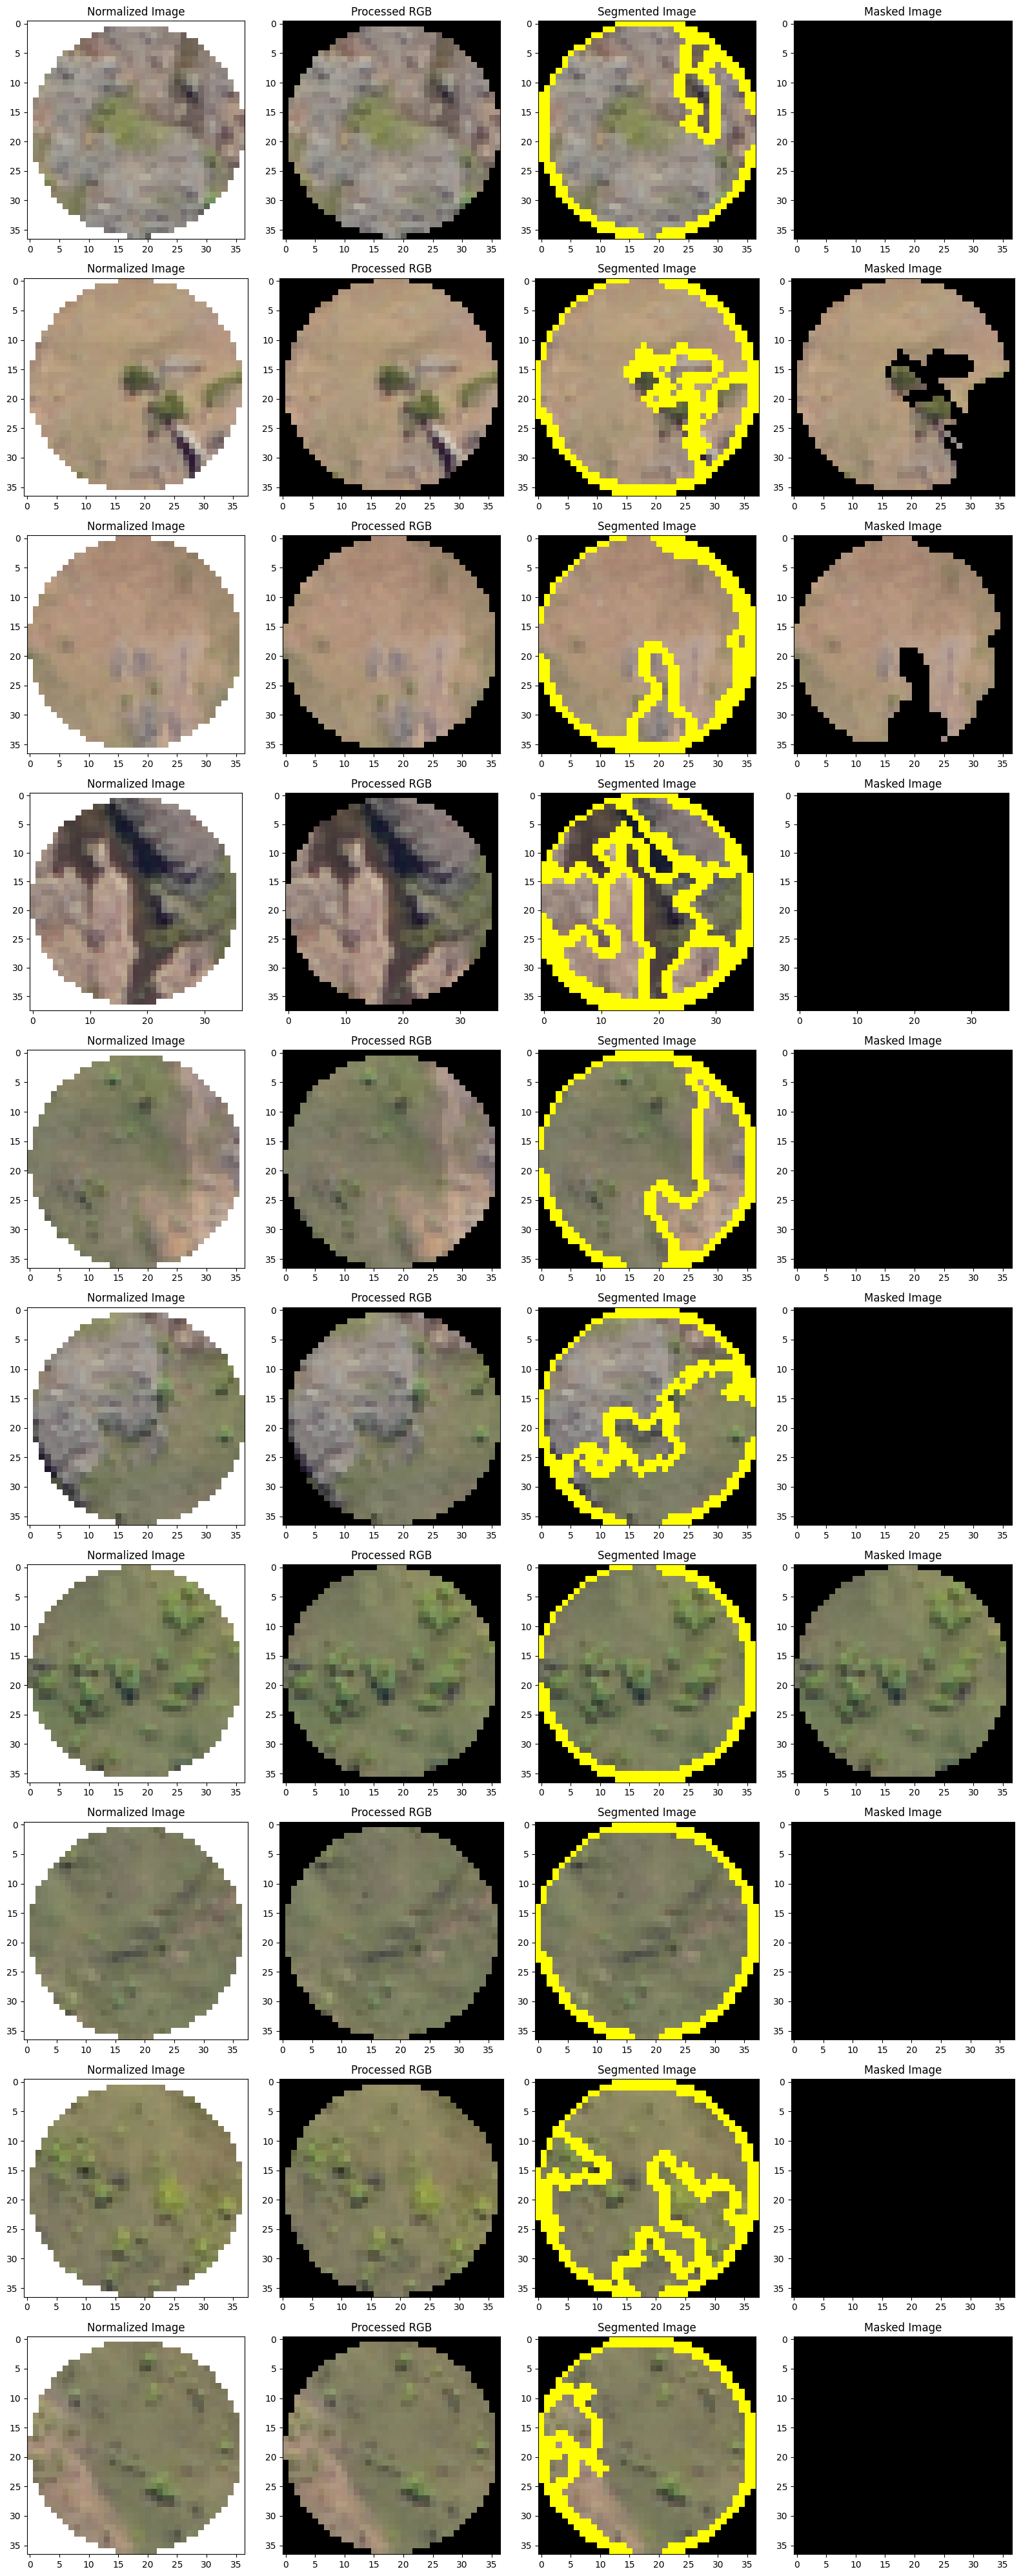

In [6]:
plot_images(normalized_images, rgb_images, imgs_segments, masked_images)

In [ ]:
from skimage.measure import regionprops, regionprops_table
import pandas as pd
import numpy as np

def extract_geometric_features(image):
    """
    Extract geometric features from a binary image of a leaf.
    
    Parameters:
    image (numpy.ndarray): Binary image of a leaf.
    
    Returns:
    pandas.DataFrame: DataFrame containing the geometric features.
    """
    props = regionprops(image)
    features = pd.DataFrame(regionprops_table(image, properties=('area', 'perimeter', 'eccentricity', 'extent')))
    features['aspect_ratio'] = props[0].major_axis_length / props[0].minor_axis_length
    features['roundness'] = 4 * np.pi * features['area'] / (features['perimeter'] ** 2)
    features['compactness'] = features['area'] / props[0].convex_area
    return features

In [ ]:
# Initialize arrays to store the color features
mean_colors = np.zeros((segments_fz.max() + 1, 3))  # for mean
std_colors = np.zeros((segments_fz.max() + 1, 3))  # for standard deviation

# Loop over each segment
for segment_id in np.unique(segments_fz):
    # Get the pixels of the segment
    segment_pixels = img[segments_fz == segment_id]
    # Calculate and store the mean and standard deviation of the RGB values of the segment
    mean_colors[segment_id] = segment_pixels.mean(axis=0)
    std_colors[segment_id] = segment_pixels.std(axis=0)

In [ ]:
# segments_qs = quickshift(img_rgb, ratio=0.5, kernel_size=3, max_dist=6, sigma=0)

In [ ]:
# fig, ax = plt.subplots(figsize = (20,20))
# plt.imshow(mark_boundaries(img_rgb, segments_qs))
# plt.show()